In [ ]:
%tensorflow_version 2.x

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io, transform

import keras
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.lib.io import file_io

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/train.zip' -d train

In [ ]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/test-private.zip' -d test

In [ ]:
# Move 80% of webcam images to the training set
%%bash
source_root='/content/dev/'
target_root='/content/train/'
IFS=$(echo -en "\n\b")
for dir in $(ls -1 "$source_root")
do
    source_dir="$source_root$dir"
    target_dir="$target_root$dir"
    num_files=$(ls -1 "$source_dir" | wc -l)
    num_to_move=$(( $num_files*8/10 ))
    echo "Moving $num_to_move/$num_files files from $source_dir to $target_dir"
    mkdir -p "$target_dir"
    cd "$source_dir"
    ls -1 "$source_dir" | shuf -n $num_to_move | xargs -i mv {} "$target_dir"
 done

Moving 373/467 files from /content/dev/0 angry to /content/train/0 angry
Moving 44/56 files from /content/dev/1 disgust to /content/train/1 disgust
Moving 396/496 files from /content/dev/2 fear to /content/train/2 fear
Moving 716/895 files from /content/dev/3 happy to /content/train/3 happy
Moving 522/653 files from /content/dev/4 sad to /content/train/4 sad
Moving 332/415 files from /content/dev/5 surprise to /content/train/5 surprise
Moving 485/607 files from /content/dev/6 neutral to /content/train/6 neutral


In [ ]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.35
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset):
    datagen = ImageDataGenerator(
                        rescale=1./255,
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='grayscale',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
X_train_gen  = get_datagen('/content/train')

Found 31577 images belonging to 7 classes.


In [ ]:
X_dev_gen    = get_datagen('/content/dev')

X_dev = np.zeros((len(X_dev_gen.filepaths), 48, 48, 1))
Y_dev = np.zeros((len(X_dev_gen.filepaths), 7))
for i in range(0,len(X_dev_gen.filepaths)):
  x = io.imread(X_dev_gen.filepaths[i], as_gray=True)
  X_dev[i,:] = transform.resize(x, (48,48,1))
  Y_dev[i,X_dev_gen.classes[i]] = 1

Found 721 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Facial Expression/Facial_Expression/models/webcam-SGD_LR_0.01000-EPOCHS_100-BS_128-DROPOUT_0.35test_acc_0.698.h5')

In [ ]:
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10)

In [ ]:
history = model.fit_generator(
    generator = X_train_gen,
    validation_data = (X_dev, Y_dev),
    shuffle=True,
    callbacks=[rlrop],
    epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
247/247 [==============================] - 91s 366ms/step - loss: 0.8644 - accuracy: 0.6791 - val_loss: 0.7182 - val_accuracy: 0.7587
Epoch 2/50
247/247 [==============================] - 92s 372ms/step - loss: 0.8707 - accuracy: 0.6739 - val_loss: 0.7271 - val_accuracy: 0.7545
Epoch 3/50
247/247 [==============================] - 91s 368ms/step - loss: 0.8646 - accuracy: 0.6788 - val_loss: 0.7185 - val_accuracy: 0.7573
Epoch 4/50
247/247 [==============================] - 91s 367ms/step - loss: 0.8674 - accuracy: 0.6765 - val_loss: 0.7204 - val_accuracy: 0.7545
Epoch 5/50
247/247 [==============================] - 92s 370ms/step - loss: 0.8692 - accuracy: 0.6750 - val_loss: 0.7236 - val_accuracy: 0.7545
Epoch 6/50
247/247 [==============================] - 91s 367ms/step - loss: 0.8676 - accuracy: 0.6763 - val_loss: 0.7172 - val_accuracy: 0.7559
Epoch 7/50
247/247 [==============================] - 91s 370ms/step - loss: 0.8681 - accuracy: 0.6778 - val_loss: 0.7227 - val_ac

KeyboardInterrupt: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


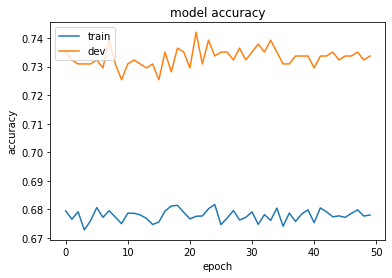

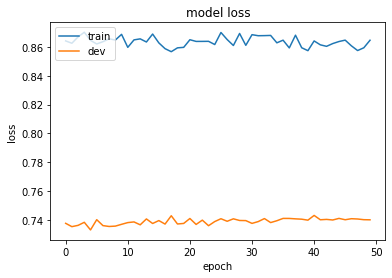

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
results_webcam = model.evaluate(X_dev, Y_dev, batch_size=BS)

lr_str = '-SGD_LR_%.5f' % SGD_LEARNING_RATE
epoch_str = '-EPOCHS_' + str(EPOCHS)
bs_str = '-BS_' + str(BS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = 'test_acc_%.3f' % results_webcam[1]
filename = '/content/drive/My Drive/Facial Expression/Facial_Expression/models/webcam' + lr_str + epoch_str + bs_str + dropout_str + test_acc + '.h5'
print(f'Saving model to {filename}...')
model.save(filename)

6/6 [==============================] - 1s 89ms/step - loss: 0.7401 - accuracy: 0.7337
Saving model to /content/drive/My Drive/Facial Expression/Facial_Expression/models/webcam-SGD_LR_0.01000-EPOCHS_50-BS_128-DROPOUT_0.35test_acc_0.734.h5...
